# Embedding Models Exploration for Qdrant / Exploración de Modelos de Embedding para Qdrant

**Goal**: Explore different embedding models to determine which one is most suitable for our RAG system for queries about Paraguayan labor law.

**Approach**:
- Compare performance of different embedding models
- Evaluate loading and search speed
- Analyze quality of results for legal queries
- Provide recommendations based on metrics

**Models to Evaluate**:
1. [**sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) – Multilingual · Lightweight · Fast  
2. [**hiiamsid/sentence_similarity_spanish_es**](https://huggingface.co/hiiamsid/sentence_similarity_spanish_es?utm_source=chatgpt.com) – Spanish · Optimized · Accurate  
3. [**jinaai/jina-embeddings-v2-base-es**](https://huggingface.co/jinaai/jina-embeddings-v2-base-es?utm_source=chatgpt.com) – Multilingual · Strong Spanish · Next-generation  
4. [**sentence-transformers/distiluse-base-multilingual-cased-v2**](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2) – Multilingual · Compact · Balanced  
5. [**intfloat/multilingual-e5-base**](https://huggingface.co/intfloat/multilingual-e5-base) – Multilingual · Base · Robust  
6. [**sentence-transformers/paraphrase-multilingual-mpnet-base-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) – Multilingual · High accuracy · MPNet  
7. [**intfloat/multilingual-e5-small**](https://huggingface.co/intfloat/multilingual-e5-small) – Multilingual · Small · Fast  
8. [**upskyy/bge-m3-korean**](https://huggingface.co/upskyy/bge-m3-korean) – Multilingual · Korean optimized · BGE  
9. [**sentence-transformers/LaBSE**](https://huggingface.co/sentence-transformers/LaBSE) – Multilingual · Broad support · Reliable  
10. [**Snowflake/snowflake-arctic-embed-l-v2.0**](https://huggingface.co/Snowflake/snowflake-arctic-embed-l-v2.0) – Multilingual · Large · High performance  
11. [**Alibaba-NLP/gte-multilingual-base**](https://huggingface.co/Alibaba-NLP/gte-multilingual-base) – Multilingual · Base · General-purpose  

---

**Objetivo**: Explorar diferentes modelos de embedding para determinar cuál es el más adecuado para nuestro sistema RAG de consultas sobre la ley laboral paraguaya.

**Enfoque**:
- Comparar rendimiento de diferentes modelos de embedding
- Evaluar velocidad de carga y búsqueda
- Analizar calidad de resultados para consultas legales
- Proporcionar recomendaciones basadas en métricas

**Modelos a Evaluar**:
1. [**sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) – Multilingüe · Ligero · Rápido
2. [**hiiamsid/sentence_similarity_spanish_es**](https://huggingface.co/hiiamsid/sentence_similarity_spanish_es?utm_source=chatgpt.com) – Español · Optimizado · Preciso
3. [**jinaai/jina-embeddings-v2-base-es**](https://huggingface.co/jinaai/jina-embeddings-v2-base-es?utm_source=chatgpt.com) – Multilingüe  · Español fuerte · Última generación
4. [**sentence-transformers/distiluse-base-multilingual-cased-v2**](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2) – Multilingüe · Compacto · Balanceado
5. [**intfloat/multilingual-e5-base**](https://huggingface.co/intfloat/multilingual-e5-base) – Multilingüe · Base · Robusto
6. [**sentence-transformers/paraphrase-multilingual-mpnet-base-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) – Multilingüe · Precisión alta · MPNet
7. [**intfloat/multilingual-e5-small**](https://huggingface.co/intfloat/multilingual-e5-small) – Multilingüe · Small · Rápido
8. [**upskyy/bge-m3-korean**](https://huggingface.co/upskyy/bge-m3-korean) – Multilingüe · Coreano optimizado · BGE
9. [**sentence-transformers/LaBSE**](https://huggingface.co/sentence-transformers/LaBSE) – Multilingüe · Amplio soporte · Confiable
10. [**Snowflake/snowflake-arctic-embed-l-v2.0**](https://huggingface.co/Snowflake/snowflake-arctic-embed-l-v2.0) – Multilingüe · Large · Alto rendimiento
11. [**Alibaba-NLP/gte-multilingual-base**](https://huggingface.co/Alibaba-NLP/gte-multilingual-base) – Multilingüe · Base · Generalista

## Setup and Configuration / Setup y Configuración


In this section you imports all the necessary libraries for the embedding model exploration. It includes:
- **Data manipulation**: pandas, numpy for data processing
- **Visualization**: matplotlib, seaborn for creating charts and graphs
- **Machine Learning**: sentence-transformers for embedding models
- **Vector Database**: qdrant-client for vector storage and search
- **Environment**: dotenv for loading environment variables
- **Utilities**: time, json, re for various operations

The libraries are configured with specific styles and settings for optimal visualization and interactive display.

---

En esta sección se importa todas las librerías necesarias para la exploración de modelos de embedding. Incluye:
- **Manipulación de datos**: pandas, numpy para procesamiento de datos
- **Visualización**: matplotlib, seaborn para crear gráficos y tablas
- **Aprendizaje automático**: sentence-transformers para modelos de embedding
- **Base de datos vectorial**: qdrant-client para almacenamiento y búsqueda vectorial
- **Entorno**: dotenv para cargar variables de entorno
- **Utilidades**: time, json, re para varias operaciones

Las librerías están configuradas con estilos y configuraciones específicas para visualización óptima y visualización interactiva.


In [1]:
# Importaciones necesarias
import os
import time
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import string
import seaborn as sns
from itables import init_notebook_mode, show
from typing import List, Dict, Any, Tuple
from pathlib import Path
from dotenv import load_dotenv

# OpenAI
from openai import OpenAI

# Qdrant y modelos de embedding
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from sentence_transformers import SentenceTransformer

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

init_notebook_mode(all_interactive=True)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


In this section you defines a custom function to load environment variables from a parent directory. The function:
- **Searches for .env file** in parent directories (configurable levels up)
- **Loads environment variables** using python-dotenv
- **Provides feedback** on successful loading or file not found

This is particularly useful when working with notebooks in subdirectories while keeping the .env file in the project root for security and organization.

---

En esta sección se define una función personalizada para cargar variables de entorno desde un directorio padre. La función:
- **Busca el archivo .env** en directorios padre (niveles hacia arriba configurables)
- **Carga las variables de entorno** usando python-dotenv
- **Proporciona retroalimentación** sobre la carga exitosa o archivo no encontrado

Esto es particularmente útil cuando se trabaja con notebooks en subdirectorios mientras se mantiene el archivo .env en la raíz del proyecto por seguridad y organización.


In [2]:
def load_env_from_parent(levels_up=1, env_filename=".env"):
    """
    Carga un archivo .env ubicado varios niveles arriba de este script.
    """
    # Obtener ruta actual de trabajo
    current_path = Path.cwd()
    
    # Subir 'levels_up' niveles
    env_path = current_path
    for _ in range(levels_up):
        env_path = env_path.parent
    env_path = env_path / env_filename
    
    if env_path.exists():
        load_dotenv(dotenv_path=env_path)
        print(f"Variables de entorno cargadas desde: {env_path}")
    else:
        print(f"Archivo {env_filename} no encontrado en: {env_path}")

# Uso
load_env_from_parent()

Variables de entorno cargadas desde: /home/joviedo/github-repos/lus-laboris-py/.env


In this section you configures the evaluation environment by:
- **Loading Qdrant connection parameters** from environment variables
- **Defining different embedding models** to evaluate, including:
  - Lightweight models (384 dimensions) for speed
  - Balanced models (768 dimensions) for quality
  - Multilingual models for Spanish language support
- **Setting up model metadata** including dimensions, descriptions, and HuggingFace model names

The configuration provides a comprehensive comparison across different model types, sizes, and specializations to find the optimal embedding model for Paraguayan labor law queries.

---

En esta sección se configura el entorno de evaluación mediante:
- **Carga de parámetros de conexión a Qdrant** desde variables de entorno
- **Definición de modelos de embedding diferentes** para evaluar, incluyendo:
  - Modelos ligeros (384 dimensiones) para velocidad
  - Modelos balanceados (768 dimensiones) para calidad
  - Modelos multilingües para soporte de idioma español
- **Configuración de metadatos de modelos** incluyendo dimensiones, descripciones y nombres de modelos de HuggingFace

La configuración proporciona una comparación integral entre diferentes tipos de modelos, tamaños y especializaciones para encontrar el modelo de embedding óptimo para consultas de ley laboral paraguaya.


In [3]:
# Configuración de conexión a Qdrant
QDRANT_URL = os.getenv('QDRANT_URL')
QDRANT_API_KEY = os.getenv('QDRANT_API_KEY')

# Configuración de modelos a probar
MODELS_TO_TEST = {
    'paraphrase-multilingual-MiniLM-L12-v2': {
        'name': 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        'description': 'Multilingüe · Ligero · Rápido',
        'dimension': 384
    },
    'sentence_similarity_spanish_es': {
        'name': 'hiiamsid/sentence_similarity_spanish_es',
        'description': 'Español · Optimizado · Preciso',
        'dimension': 768
    },
    'jina-embeddings-v2-base-es': {
        'name': 'jinaai/jina-embeddings-v2-base-es',
        'description': 'Multilingüe · Español fuerte · Última generación',
        'dimension': 768
    },
    'distiluse-base-multilingual-cased-v2': {
        'name': 'sentence-transformers/distiluse-base-multilingual-cased-v2',
        'description': 'Multilingüe · Compacto · Balanceado',
        'dimension': 512
    },
    'multilingual-e5-base': {
        'name': 'intfloat/multilingual-e5-base',
        'description': 'Multilingüe · Base · Robusto',
        'dimension': 768
    },
    'paraphrase-multilingual-mpnet-base-v2': {
        'name': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
        'description': 'Multilingüe · Precisión alta · MPNet',
        'dimension': 768
    },
    'multilingual-e5-small': {
        'name': 'intfloat/multilingual-e5-small',
        'description': 'Multilingüe · Small · Rápido',
        'dimension': 384
    },
    'bge-m3-korean': {
        'name': 'upskyy/bge-m3-korean',
        'description': 'Multilingüe · Coreano optimizado · BGE',
        'dimension': 1024
    },
    'LaBSE': {
        'name': 'sentence-transformers/LaBSE',
        'description': 'Multilingüe · Amplio soporte · Confiable',
        'dimension': 768
    },
    'snowflake-arctic-embed-l-v2.0': {
        'name': 'Snowflake/snowflake-arctic-embed-l-v2.0',
        'description': 'Multilingüe · Large · Alto rendimiento',
        'dimension': 1024
    },
    'gte-multilingual-base': {
        'name': 'Alibaba-NLP/gte-multilingual-base',
        'description': 'Multilingüe · Large · Alto rendimiento',
        'dimension': 768
    }
}

    
print(f"Conectando a Qdrant en: {QDRANT_URL}")
print(f"Modelos a evaluar: {len(MODELS_TO_TEST)}")


Conectando a Qdrant en: http://localhost:6333
Modelos a evaluar: 11


In this section you loads the actual Paraguayan labor law data from a processed JSON file. The function:
- **Reads the JSON file** containing structured labor law articles
- **Displays metadata** about the law (law number, promulgation date, publication date)
- **Shows statistics** about the total number of articles loaded

The data structure includes articles organized by books, titles, and chapters, providing a comprehensive dataset for testing embedding models with real legal content.

---

En esta sección se carga los datos reales de la ley laboral paraguaya desde un archivo JSON procesado. La función:
- **Lee el archivo JSON** que contiene artículos de ley laboral estructurados
- **Muestra metadatos** sobre la ley (número de ley, fecha de promulgación, fecha de publicación)
- **Muestra estadísticas** sobre el número total de artículos cargados

La estructura de datos incluye artículos organizados por libros, títulos y capítulos, proporcionando un conjunto de datos integral para probar modelos de embedding con contenido legal real.


In [6]:
# Cargar datos reales de la ley laboral paraguaya
def load_labor_law_data(json_path="../data/processed/codigo_trabajo_articulos.json"):
    """Cargar y procesar los datos reales de la ley laboral"""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            law_data = json.load(f)
        
        print(f"Datos cargados exitosamente desde: {json_path}")
        print(f"Metadatos de la ley: {law_data['meta']}")
        print(f"Total de artículos: {len(law_data['articulos'])}")
        
        return law_data
    except Exception as e:
        print(f"Error cargando datos: {e}")
        return None

In [7]:
# Cargar datos reales
law_data = load_labor_law_data()

law_data['articulos'][:2]

Datos cargados exitosamente desde: ../data/processed/codigo_trabajo_articulos.json
Metadatos de la ley: {'numero_ley': '213', 'fecha_promulgacion': '29-06-1993', 'fecha_publicacion': '29-10-1993'}
Total de artículos: 410


[{'articulo_numero': 1,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo primero',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'del objeto y aplicación del código',
  'articulo': 'este código tiene por objeto establecer normas para regular las relaciones entre los trabajadores y empleadores, concernientes a la prestación subordinada y retribuida de la actividad laboral.'},
 {'articulo_numero': 2,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo primero',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'del objeto y aplicación del código',
  'articulo': 'estarán sujetos a las disposiciones del presente código:los trabajadores intelectuales, manuales o técnicos en relación de dependencia y sus empleadores. los profesores de institutos de enseñanza privada y quienes ejerzan la práctica deportiva profesional.los sindicatos de trabajadores y empleadores del sector privado.los trabajadores

## Selecting Sample Articles and Test Queries / Selección de artículos y consultas de prueba

In this section you organizes the loaded labor law articles by their chapters for systematic sampling. The process:
- **Groups articles by chapter** to understand the distribution across different legal topics
- **Creates a dictionary structure** where each chapter contains its associated articles
- **Enables representative sampling** by ensuring articles from different chapters are included

This organization is crucial for creating a balanced test dataset that covers various aspects of labor law, from basic definitions to specific regulations.

---

En esta sección se organiza los artículos de ley laboral cargados por sus capítulos para muestreo sistemático. El proceso:
- **Agrupa artículos por capítulo** para entender la distribución a través de diferentes temas legales
- **Crea una estructura de diccionario** donde cada capítulo contiene sus artículos asociados
- **Habilita muestreo representativo** asegurando que se incluyan artículos de diferentes capítulos

Esta organización es crucial para crear un conjunto de datos de prueba balanceado que cubra varios aspectos de la ley laboral, desde definiciones básicas hasta regulaciones específicas.


In [8]:
# Extraer textos de los artículos para las pruebas
# Usar una muestra representativa de diferentes capítulos
articles_by_chapter = {}
for article in law_data['articulos']:
    chapter = article['capitulo_descripcion']
    if chapter not in articles_by_chapter:
        articles_by_chapter[chapter] = []
    articles_by_chapter[chapter].append(article)

In [9]:
len(articles_by_chapter), type(articles_by_chapter)

(31, dict)

In [10]:
articles_by_chapter['definición, sujetos y objetos'][:2]

[{'articulo_numero': 16,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo segundo',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'definición, sujetos y objetos',
  'articulo': 'el estado tomará a su cargo brindar educación profesional y técnica a trabajadores de modo a perfeccionar sus aptitudes para obtener mejores ingresos y una mayor eficiencia en la producción.mediante una política económica adecuada procurará igualmente mantener un justo equilibrio de la oferta y la demanda de mano de obra, dar empleo apropiado a los trabajadores desocupados o no ocupados plenamente por causas ajenas a su voluntad, a los minusválidos físicos y psíquicos, ancianos y veteranos de la guerra.'},
 {'articulo_numero': 17,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo segundo',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'definición, sujetos y objetos',
  'articulo': 'contrato de trabajo es el co

In this section you create a representative sample of labor law articles for testing. The selection process:
- **Takes articles from the first 8 chapters** to ensure diversity
- **Selects 1-4 articles per chapter** (up to 4 articles maximum per chapter)
- **Creates formatted text strings** combining chapter description with article content
- **Stores metadata** for each selected article including book, title, chapter, and article number

This sampling strategy ensures the test dataset covers different legal topics while maintaining a manageable size for efficient model evaluation.

---

En esta sección se crea una muestra representativa de artículos de ley laboral para pruebas. El proceso de selección:
- **Toma artículos de los primeros 8 capítulos** para asegurar diversidad
- **Selecciona 1-4 artículos por capítulo** (máximo 4 artículos por capítulo)
- **Crea cadenas de texto formateadas** combinando descripción del capítulo con contenido del artículo
- **Almacena metadatos** para cada artículo seleccionado incluyendo libro, título, capítulo y número de artículo

Esta estrategia de muestreo asegura que el conjunto de datos de prueba cubra diferentes temas legales mientras mantiene un tamaño manejable para evaluación eficiente de modelos.


In [11]:
# Seleccionar artículos representativos de diferentes capítulos
SAMPLE_LEGAL_TEXTS = []
selected_articles = []
cant_capitulo = 8

for chapter, articles in list(articles_by_chapter.items())[:cant_capitulo]:  # Primeros 8 capítulo
    # Tomar 1-4 artículos por capítulo
    sample_size = min(4, len(articles))
    chapter_articles = articles[:sample_size]
    
    for article in chapter_articles:
        SAMPLE_LEGAL_TEXTS.append(f"{chapter}: {article['articulo']}")
        selected_articles.append({
            'libro': article['libro'],
            'titulo': article['titulo'],
            'capitulo': article['capitulo'],
            'capitulo_descripcion': chapter,
            'articulo_numero': article['articulo_numero'],
            'articulo': article['articulo'][:80] + "..."  # Preview
        })

In [12]:
SAMPLE_LEGAL_TEXTS[-2], selected_articles[-2]

('del período de prueba en la etapa inicial del contrato: establécese en la etapa inicial del contrato de trabajo, un período de prueba que tendrá por objeto respecto\xa0del empleador, apreciar las aptitudes del trabajador y, de parte de éste, verificar la conveniencia de las condiciones del trabajo\xa0contratado.dicho período tendrá como máximo la siguiente duración:a) de treinta días para el personal del servicio doméstico y trabajadores no calificados;b) de sesenta días, para trabajadores calificados o para aprendices; y,c) tratándose de trabajadores técnicos altamente especializados, las partes podrán convenir un período distinto del anterior,\xa0conforme a las modalidades del trabajo contratado.',
 {'libro': 'libro primero',
  'titulo': 'titulo segundo',
  'capitulo': 'capitulo vi',
  'capitulo_descripcion': 'del período de prueba en la etapa inicial del contrato',
  'articulo_numero': 58,
  'articulo': 'establécese en la etapa inicial del contrato de trabajo, un período de prueba

In this section you sets up OpenAI integration and defines functions for generating semantic queries. The functionality includes:
- **OpenAI client initialization** for using GPT models
- **Query generation function** that creates 2 questions per chapter using GPT-4o-mini
- **JSON parsing utility** to extract structured responses from the AI
- **Targeted question creation** that focuses on specific articles within each chapter

The generated queries are designed to test the embedding models' ability to find relevant legal information, simulating real-world user questions about Paraguayan labor law.

---

En esta sección se configura la integración con OpenAI y define funciones para generar consultas semánticas. La funcionalidad incluye:
- **Inicialización del cliente OpenAI** para usar modelos GPT
- **Función de generación de consultas** que crea 2 preguntas por capítulo usando GPT-4o-mini
- **Utilidad de parsing JSON** para extraer respuestas estructuradas de la IA
- **Creación de preguntas dirigidas** que se enfocan en artículos específicos dentro de cada capítulo

Las consultas generadas están diseñadas para probar la capacidad de los modelos de embedding para encontrar información legal relevante, simulando preguntas del mundo real sobre la ley laboral paraguaya.


In [13]:
# Inicializa el cliente de OpenAI (asegurate de tener OPENAI_API_KEY en tu entorno)
client = OpenAI()

print("Modelos disponibles para usar")
print([m.id for m in client.models.list()])

Modelos disponibles para usar
['gpt-4o-mini', 'gpt-4.1']


In [14]:
def parse_model_response(response_text: str):
    # Eliminar triple backticks y etiqueta opcional
    cleaned = re.sub(r"```(?:json)?", "", response_text).strip()
    
    # Parsear JSON
    return json.loads(cleaned)


def generate_semantic_questions(chapters_dict, cant_chapters, max_article=4):
    """
    Genera 2 preguntas por capítulo que apunten a los primeros 4 artículos del capítulo.
    """
    questions = []
    chapters = dict(list(chapters_dict.items())[:cant_chapters])

    for chapter, top_articles in chapters.items():
        
        prompt = f"""
        Genera 2 preguntas sobre el siguiente capítulo: "{chapter}".
        Cada pregunta debe poder ser respondida usando alguno de los {max_article} primeros artículos.
        
        Responde como un array de JSON, respetando la siguiente estructura:
        <FOMRATO_SALIDAD>
        [
            {{"question": "...", target_article": numero_articulo}},
            {{"question": "...", "target_article": numero_articulo}}
        ]
        </FOMRATO_SALIDAD>
        
        Capítulo texto resumido de los primeros 4 artículos: 
        {json.dumps([a['articulo'] for a in top_articles], ensure_ascii=False)}
        """
        
        response = client.responses.create(
            model="gpt-4o-mini",
            input=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "input_text",
                            "text": prompt
                        }
                    ]
                }
            ]
        )

        # Obtener texto de la respuesta
        content = response.output_text

        chapter_questions = parse_model_response(content)
        for q in chapter_questions:
            questions.append({
                "question": q["question"],
                "chapter": chapter,
                "target_articulo": q["target_article"]
            })
    
    return questions

In [ ]:
# Ejecutar una sola vez:
# Genera un conjunto inicial de preguntas semánticas diseñadas para obtener 
# buenos resultados a partir de los `selected_articles`.
# Estas preguntas se usan como dataset de referencia para evaluar la calidad 
# de los embeddings y las búsquedas en Qdrant.
# Copia el resultado en la variable queries_and_responses

#generated_questions = generate_semantic_questions(articles_by_chapter, cant_capitulo)
#generated_questions

In [15]:
queries_and_responses = [
 {'question': '¿Cuál es el objetivo principal del código en relación con las relaciones laborales?',
  'chapter': 'del objeto y aplicación del código',
  'target_articulo': 1},
 {'question': '¿Qué tipos de trabajadores están sujetos a las disposiciones de este código?',
  'chapter': 'del objeto y aplicación del código',
  'target_articulo': 2},
 {'question': '¿Qué debe prevalecer en caso de dudas sobre la interpretación o aplicación de las normas de trabajo?',
  'chapter': 'del trabajo y sus garantías',
  'target_articulo': 1},
 {'question': '¿Cómo se define el trabajo?',
  'chapter': 'del trabajo y sus garantías',
  'target_articulo': 2},
 {'question': '¿Quiénes son los sujetos que celebran el contrato de trabajo?',
  'chapter': 'definición, sujetos y objetos',
  'target_articulo': 5},
 {'question': '¿Qué se considera como el objeto del contrato de trabajo?',
  'chapter': 'definición, sujetos y objetos',
  'target_articulo': 12},
 {'question': '¿Quiénes tienen plena capacidad para celebrar un contrato de trabajo según el artículo 2?',
  'chapter': 'de la capacidad para contratar',
  'target_articulo': 2},
 {'question': '¿Qué condiciones deben cumplirse para que un menor entre en un contrato de trabajo según el artículo 3?',
  'chapter': 'de la capacidad para contratar',
  'target_articulo': 3},
 {'question': '¿Qué características debe tener un contrato de trabajo para ser válido según la voluntad de las partes?',
  'chapter': 'de las limitaciones a la libertad contractual',
  'target_articulo': 2},
 {'question': '¿Qué tipo de cláusulas se consideran nulas en un contrato laboral?',
  'chapter': 'de las limitaciones a la libertad contractual',
  'target_articulo': 4},
 {'question': '¿Qué ocurre si una parte del contrato de trabajo resulta nula?',
  'chapter': 'de las modalidades del contrato',
  'target_articulo': 1},
 {'question': '¿Cuándo es obligatorio que un contrato de trabajo se realice por escrito?',
  'chapter': 'de las modalidades del contrato',
  'target_articulo': 2},
 {'question': '¿Qué autorización necesita el jefe elegido del grupo para gestionar el salario global?',
  'chapter': 'de los gastos del contrato',
  'target_articulo': 1},
 {'question': '¿Bajo qué condiciones el empleador está exento de pagar los gastos de traslado al trabajador?',
  'chapter': 'de los gastos del contrato',
  'target_articulo': 2},
 {'question': '¿Cuál es la duración máxima del período de prueba para trabajadores no calificados?',
  'chapter': 'del período de prueba en la etapa inicial del contrato',
  'target_articulo': 2},
 {'question': '¿Qué debe ocurrir al término del período de prueba si ninguna de las partes manifiesta su voluntad de terminar el contrato?',
  'chapter': 'del período de prueba en la etapa inicial del contrato',
  'target_articulo': 3}
]

In [16]:
# Consultas específicas basadas en el contenido real de la ley
SAMPLE_QUERIES = [queries['question'] for queries in queries_and_responses]

print(f"\nResumen de datos cargados:")
print(f"\tTextos seleccionados: {len(SAMPLE_LEGAL_TEXTS)}")
print(f"\tConsultas de prueba: {len(SAMPLE_QUERIES)}")
print(f"\tCapítulos representados: {len(articles_by_chapter)}")


Resumen de datos cargados:
	Textos seleccionados: 29
	Consultas de prueba: 16
	Capítulos representados: 31


In [17]:
# Mostrar algunos artículos seleccionados
print(f"\nArtículos seleccionados para las pruebas:")
for i, article in enumerate(selected_articles[:5]):
    print(f"{i+1}. Artículo {article['articulo_numero']} - {article['capitulo']}")
    print(f"   {article['articulo']}")
    print()


Artículos seleccionados para las pruebas:
1. Artículo 1 - capitulo i
   este código tiene por objeto establecer normas para regular las relaciones entre...

2. Artículo 2 - capitulo i
   estarán sujetos a las disposiciones del presente código:los trabajadores intelec...

3. Artículo 3 - capitulo i
   los derechos reconocidos por este código a los trabajadores no podrán ser objeto...

4. Artículo 4 - capitulo i
   los reglamentos de fábricas o talleres, contratos individuales y colectivos de t...

5. Artículo 7 - capitulo ii
   si se suscitase duda sobre interpretación o aplicación de las normas de trabajo,...



## Statistical Analysis of Paraguay’s Labor Law / Análisis estadístico de la Ley Laboral Paraguaya

In [18]:
# Análisis estadístico de los datos cargados
print("ANÁLISIS ESTADÍSTICO DE LA LEY LABORAL")
print("=" * 50)

# Estadísticas generales
total_articles = len(law_data['articulos'])
total_chapters = len(set(article['capitulo_descripcion'] for article in law_data['articulos']))
total_books = len(set(article['libro'] for article in law_data['articulos'] if article['libro']))

print(f"Libros: {total_books}")
print(f"Capítulos: {total_chapters}")
print(f"Artículos totales: {total_articles}")

ANÁLISIS ESTADÍSTICO DE LA LEY LABORAL
Libros: 5
Capítulos: 31
Artículos totales: 410


In [19]:
# Longitud promedio de textos
text_lengths = [len(article['articulo']) for article in law_data['articulos']]
avg_length = np.mean(text_lengths)
min_length = np.min(text_lengths)
max_length = np.max(text_lengths)

print(f"\n Estadísticas de longitud de texto:")
print(f"\tPromedio: {avg_length:.0f} caracteres")
print(f"\tMínimo: {min_length} caracteres")
print(f"\tMáximo: {max_length} caracteres")


 Estadísticas de longitud de texto:
	Promedio: 441 caracteres
	Mínimo: 61 caracteres
	Máximo: 5057 caracteres


In [20]:
# Distribución por capítulos
chapter_counts = {}
for article in law_data['articulos']:
    chapter = article['capitulo_descripcion']
    chapter_counts[chapter] = chapter_counts.get(chapter, 0) + 1

print(f"\nTop 5 capítulos con más artículos:")
sorted_chapters = sorted(chapter_counts.items(), key=lambda x: x[1], reverse=True)
for i, (chapter, count) in enumerate(sorted_chapters[:5]):
    print(f"\t{i+1}. {chapter}: {count} artículos")


Top 5 capítulos con más artículos:
	1. de la estabilidad sindical: 41 artículos
	2. de los paros: 36 artículos
	3. del trabajo rural: 35 artículos
	4. del trabajo en las empresas de transporte automotor terrestre: 35 artículos
	5. de la asignación familiar: 22 artículos


In [21]:
# Muestra de artículos seleccionados para las pruebas
print(f"\nMuestra seleccionada para pruebas:")
print(f"\tArtículos en muestra: {len(SAMPLE_LEGAL_TEXTS)}")
print(f"\tConsultas de prueba: {len(SAMPLE_QUERIES)}")


Muestra seleccionada para pruebas:
	Artículos en muestra: 29
	Consultas de prueba: 16


In [22]:
sampling_ratio = len(SAMPLE_LEGAL_TEXTS) / total_articles

if sampling_ratio < 0.05:
    print(f"La muestra cubre solo el {sampling_ratio:.2%} de los artículos, ampliar para mayor representatividad")
else:
    print(f"La muestra cubre el {sampling_ratio:.2%} de los artículos, representativa para pruebas")

La muestra cubre el 7.07% de los artículos, representativa para pruebas


## Model Loading and Evaluation / Carga y Evaluación de Modelos

In this section you defines a comprehensive evaluator class for testing embedding models. The class provides:
- **Qdrant connection management** for vector database operations
- **Model loading with timing** to measure initialization performance
- **Embedding generation with timing** to measure processing speed
- **Error handling** for robust evaluation across different models
- **Results storage** for later analysis and comparison

The evaluator is designed to systematically test all configured models, measuring both performance metrics (speed) and quality metrics (similarity) to enable data-driven model selection.

---

En esta sección se define una clase evaluadora integral para probar modelos de embedding. La clase proporciona:
- **Gestión de conexión a Qdrant** para operaciones de base de datos vectorial
- **Carga de modelos con cronometraje** para medir rendimiento de inicialización
- **Generación de embeddings con cronometraje** para medir velocidad de procesamiento
- **Manejo de errores** para evaluación robusta a través de diferentes modelos
- **Almacenamiento de resultados** para análisis y comparación posterior

El evaluador está diseñado para probar sistemáticamente todos los modelos configurados, midiendo tanto métricas de rendimiento (velocidad) como métricas de calidad (similitud) para permitir selección de modelos basada en datos.


In [25]:
class EmbeddingModelEvaluator:
    """Clase para evaluar modelos de embedding"""
    
    def __init__(self, qdrant_url: str, qdrant_api_key: str = None):
        self.qdrant_url = qdrant_url
        self.qdrant_api_key = qdrant_api_key
        self.client = None
        self.results = {}
        
    def connect_qdrant(self):
        """Conectar a Qdrant"""
        try:
            self.client = QdrantClient(
                url=self.qdrant_url,
                api_key=self.qdrant_api_key
            )
            print("Conexión a Qdrant establecida")
            return True
        except Exception as e:
            print(f"Error conectando a Qdrant: {e}")
            return False
    
    def load_model_and_measure_time(self, model_name: str) -> Tuple[SentenceTransformer, float]:
        """Cargar modelo y medir tiempo de carga"""
        print(f"📥 Cargando modelo: {model_name}")
        start_time = time.time()
        
        try:
            model = SentenceTransformer(model_name, trust_remote_code=True)
            load_time = time.time() - start_time
            print(f"✅ Modelo cargado en {load_time:.2f} segundos")
            return model, load_time
        except Exception as e:
            print(f"❌ Error cargando modelo {model_name}: {e}")
            return None, 0
    
    def create_embeddings_and_measure_time(self, model: SentenceTransformer, texts: List[str]) -> Tuple[np.ndarray, float]:
        """Crear embeddings y medir tiempo"""
        print(f"🔄 Generando embeddings para {len(texts)} articulos...")
        start_time = time.time()
        
        embeddings = model.encode(texts, convert_to_tensor=False)
        embedding_time = time.time() - start_time
        
        print(f"✅ Embeddings generados en {embedding_time:.2f} segundos")
        return embeddings, embedding_time

# Inicializar evaluador
evaluator = EmbeddingModelEvaluator(QDRANT_URL, QDRANT_API_KEY)
evaluator.connect_qdrant()

Conexión a Qdrant establecida


/tmp/ipykernel_246979/1087359154.py:13: UserWarning: Api key is used with an insecure connection.
  self.client = QdrantClient(


True

In [26]:
# Ejecutar evaluación completa de todos los modelos
model_performance = {}

print("Iniciando evaluación de modelos de embedding...")
print("=" * 60)

for model_key, model_config in MODELS_TO_TEST.items():
    print(f"\nEvaluando: {model_config['name']}")
    print(f"Descripción: {model_config['description']}")
    print("-" * 40)
    
    # Cargar modelo
    model, load_time = evaluator.load_model_and_measure_time(model_config['name'])
    
    if model is None:
        continue
    
    # Generar embeddings
    embeddings, embedding_time = evaluator.create_embeddings_and_measure_time(model, SAMPLE_LEGAL_TEXTS)
    
    # Almacenar resultados
    model_performance[model_key] = {
        'name': model_config['name'],
        'description': model_config['description'],
        'dimension': model_config['dimension'],
        'load_time': load_time,
        'embedding_time': embedding_time,
        'embeddings': embeddings,
        'model': model
    }
    
    print(f"📊 Dimensiones: {embeddings.shape}")
    print(f"⏱️ Tiempo total: {load_time + embedding_time:.2f}s")

print("\nEvaluación de modelos completada!")
print(f"Modelos evaluados exitosamente: {len(model_performance)}")


Iniciando evaluación de modelos de embedding...

Evaluando: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Descripción: Multilingüe · Ligero · Rápido
----------------------------------------
📥 Cargando modelo: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
✅ Modelo cargado en 3.71 segundos
🔄 Generando embeddings para 29 articulos...
✅ Embeddings generados en 0.90 segundos
📊 Dimensiones: (29, 384)
⏱️ Tiempo total: 4.61s

Evaluando: hiiamsid/sentence_similarity_spanish_es
Descripción: Español · Optimizado · Preciso
----------------------------------------
📥 Cargando modelo: hiiamsid/sentence_similarity_spanish_es
✅ Modelo cargado en 2.71 segundos
🔄 Generando embeddings para 29 articulos...
✅ Embeddings generados en 4.96 segundos
📊 Dimensiones: (29, 768)
⏱️ Tiempo total: 7.67s

Evaluando: jinaai/jina-embeddings-v2-base-es
Descripción: Multilingüe · Español fuerte · Última generación
----------------------------------------
📥 Cargando modelo: jinaai/jina-embedding

configuration_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-v2-qk-devlin-norm-1e-2:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-v2-qk-devlin-norm-1e-2:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


✅ Modelo cargado en 19.18 segundos
🔄 Generando embeddings para 29 articulos...
✅ Embeddings generados en 8.28 segundos
📊 Dimensiones: (29, 768)
⏱️ Tiempo total: 27.46s

Evaluando: sentence-transformers/distiluse-base-multilingual-cased-v2
Descripción: Multilingüe · Compacto · Balanceado
----------------------------------------
📥 Cargando modelo: sentence-transformers/distiluse-base-multilingual-cased-v2
✅ Modelo cargado en 3.83 segundos
🔄 Generando embeddings para 29 articulos...
✅ Embeddings generados en 7.65 segundos
📊 Dimensiones: (29, 512)
⏱️ Tiempo total: 11.48s

Evaluando: intfloat/multilingual-e5-base
Descripción: Multilingüe · Base · Robusto
----------------------------------------
📥 Cargando modelo: intfloat/multilingual-e5-base
✅ Modelo cargado en 12.45 segundos
🔄 Generando embeddings para 29 articulos...
✅ Embeddings generados en 15.13 segundos
📊 Dimensiones: (29, 768)
⏱️ Tiempo total: 27.58s

Evaluando: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Descripción

configuration.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/611M [00:00<?, ?B/s]

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Modelo cargado en 55.71 segundos
🔄 Generando embeddings para 29 articulos...
✅ Embeddings generados en 8.86 segundos
📊 Dimensiones: (29, 768)
⏱️ Tiempo total: 64.57s

Evaluación de modelos completada!
Modelos evaluados exitosamente: 11


## Performance and Speed Analysis / Análisis de Rendimiento y Velocidad

In this section you analyzes the performance metrics collected during model evaluation and creates comprehensive visualizations. The analysis includes:
- **Performance data compilation** into a structured DataFrame
- **Speed calculations** including texts per second processing rate
- **Multi-panel visualizations** showing loading time, embedding time, and processing speed
- **Model comparison charts** with labeled axes and legends
- **Performance rankings** identifying the fastest models in different categories

The visualizations help identify trade-offs between model complexity, processing speed, and resource requirements, enabling informed decisions about model selection for different use cases.

---

En esta sección se analiza las métricas de rendimiento recolectadas durante la evaluación de modelos y crea visualizaciones integrales. El análisis incluye:
- **Compilación de datos de rendimiento** en un DataFrame estructurado
- **Cálculos de velocidad** incluyendo tasa de procesamiento de textos por segundo
- **Visualizaciones de múltiples paneles** mostrando tiempo de carga, tiempo de embedding y velocidad de procesamiento
- **Gráficos de comparación de modelos** con ejes etiquetados y leyendas
- **Rankings de rendimiento** identificando los modelos más rápidos en diferentes categorías

Las visualizaciones ayudan a identificar compensaciones entre complejidad del modelo, velocidad de procesamiento y requisitos de recursos, permitiendo decisiones informadas sobre selección de modelos para diferentes casos de uso.

In [27]:
# Crear DataFrame con resultados de rendimiento
performance_data = []

for model_key, data in model_performance.items():
    performance_data.append({
        'Modelo': model_key,
        'Nombre Completo': data['name'],
        'Descripción': data['description'],
        'Dimensiones': data['dimension'],
        'Tiempo Carga (s)': data['load_time'],
        'Tiempo Embedding (s)': data['embedding_time'],
        'Tiempo Total (s)': data['load_time'] + data['embedding_time'],
        'Velocidad (textos/s)': len(SAMPLE_LEGAL_TEXTS) / data['embedding_time']
    })

df_performance = pd.DataFrame(performance_data)
print("\nResumen de Rendimiento de Modelos:")
df_performance.round(3)


Resumen de Rendimiento de Modelos:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


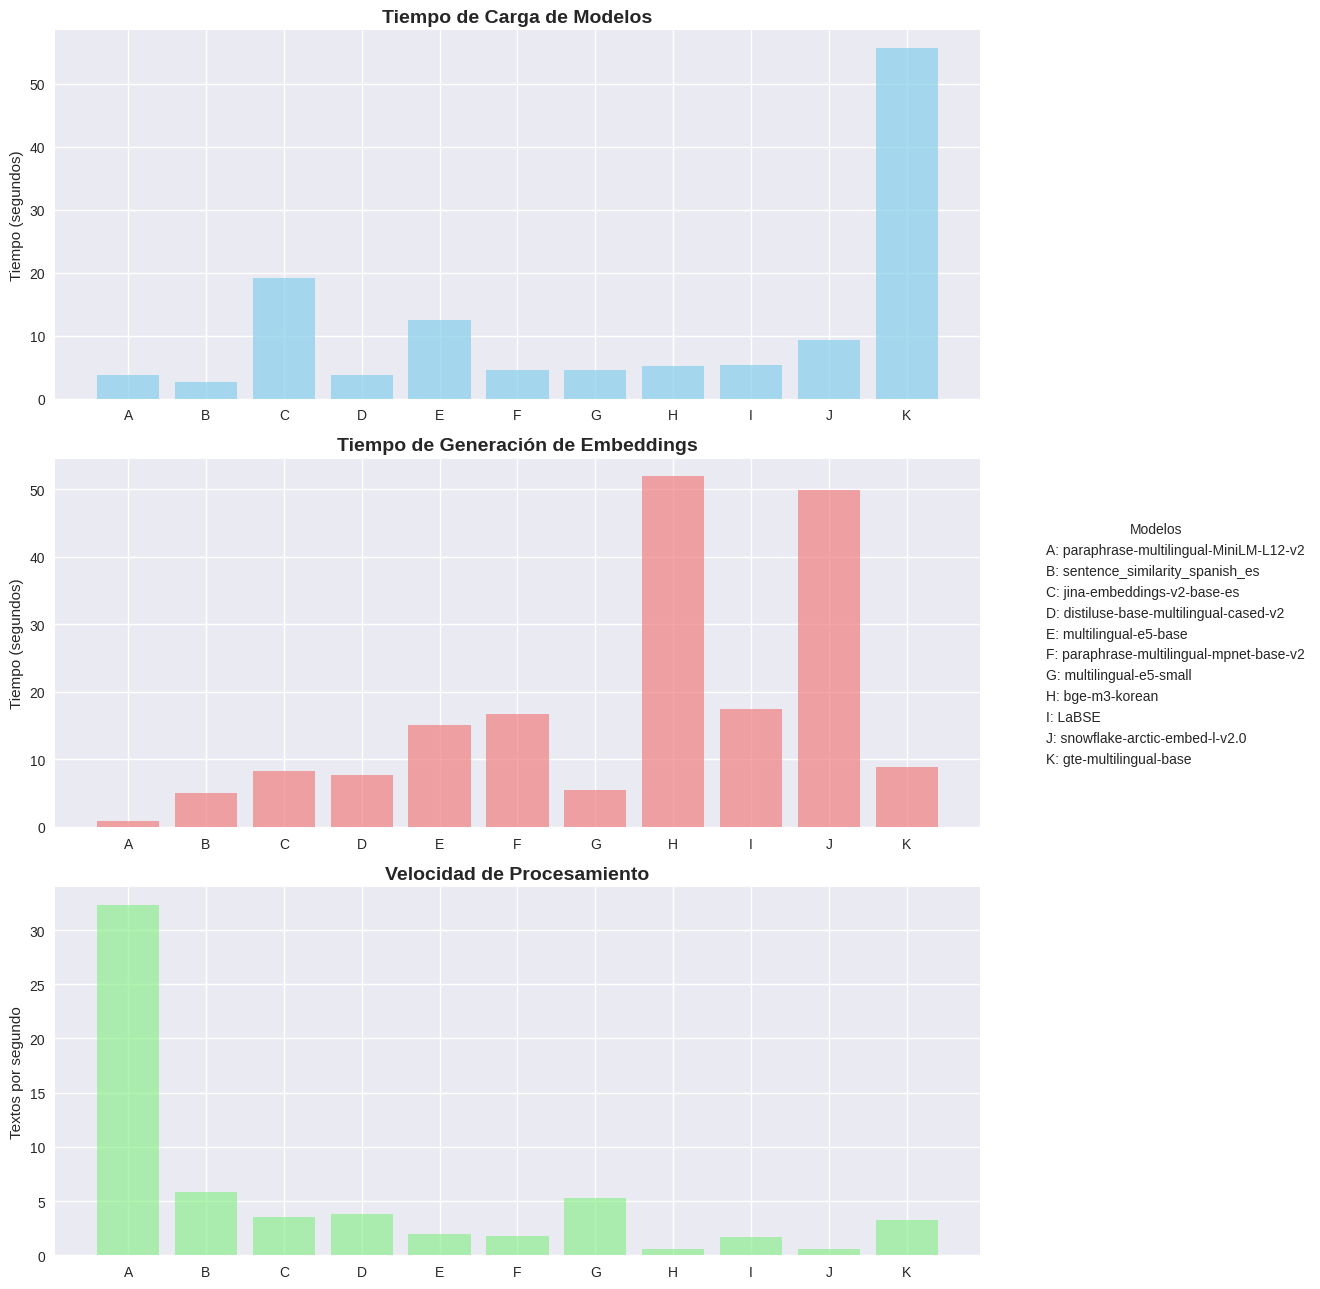

In [30]:
df_performance['Etiqueta'] = list(string.ascii_uppercase[:len(df_performance)])

# Visualización de tiempos de carga y embedding
fig, axes = plt.subplots(3, 1, figsize=(10, 13))

# Gráfico 1: Tiempos de carga
axes[0].bar(df_performance['Etiqueta'], df_performance['Tiempo Carga (s)'], 
           color='skyblue', alpha=0.7)
axes[0].set_title('Tiempo de Carga de Modelos', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Tiempo (segundos)')
axes[0].tick_params(axis='x')

# Gráfico 2: Tiempos de embedding
axes[1].bar(df_performance['Etiqueta'], df_performance['Tiempo Embedding (s)'], 
           color='lightcoral', alpha=0.7)
axes[1].set_title('Tiempo de Generación de Embeddings', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Tiempo (segundos)')
axes[1].tick_params(axis='x')

# Gráfico 3: Velocidad de procesamiento
axes[2].bar(df_performance['Etiqueta'], df_performance['Velocidad (textos/s)'], 
           color='lightgreen', alpha=0.7)
axes[2].set_title('Velocidad de Procesamiento', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Textos por segundo')
axes[2].tick_params(axis='x')

plt.tight_layout()

# Crear "handles" para la leyenda (mapeo Etiqueta → Modelo)
handles = [mpatches.Patch(color="white", label=f"{row.Etiqueta}: {row.Modelo}")
           for row in df_performance.itertuples()]

# Mostrar la leyenda a la derecha, fuera de los ejes
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(1, 0.5),
           title="Modelos", fontsize=10)

plt.show()

In [31]:
# Mostrar el modelo más rápido en cada categoría
print("\nMejores Rendimientos:")
print(f"\tCarga más rápida: {df_performance.loc[df_performance['Tiempo Carga (s)'].idxmin(), 'Modelo']}")
print(f"\tEmbedding más rápido: {df_performance.loc[df_performance['Tiempo Embedding (s)'].idxmin(), 'Modelo']}")
print(f"\tMayor velocidad: {df_performance.loc[df_performance['Velocidad (textos/s)'].idxmax(), 'Modelo']}")


Mejores Rendimientos:
	Carga más rápida: sentence_similarity_spanish_es
	Embedding más rápido: paraphrase-multilingual-MiniLM-L12-v2
	Mayor velocidad: paraphrase-multilingual-MiniLM-L12-v2


## Search Quality Evaluation / Evaluación de Calidad de Búsqueda

In this section you defines functions to evaluate the quality of search results from embedding models. The evaluation includes:
- **Cosine similarity calculation** to measure semantic similarity between queries and documents
- **Search quality assessment** that tests each model with all sample queries
- **Performance timing** to measure search speed for each model
- **Result ranking** to identify the best matches for each query
- **Average similarity calculation** to compare overall model performance

This evaluation is crucial for determining which embedding model provides the most accurate and relevant search results for legal queries, which is the primary goal of the RAG system.

---

En esta sección se define funciones para evaluar la calidad de los resultados de búsqueda de los modelos de embedding. La evaluación incluye:
- **Cálculo de similitud coseno** para medir similitud semántica entre consultas y documentos
- **Evaluación de calidad de búsqueda** que prueba cada modelo con todas las consultas de muestra
- **Cronometraje de rendimiento** para medir velocidad de búsqueda para cada modelo
- **Ranking de resultados** para identificar las mejores coincidencias para cada consulta
- **Cálculo de similitud promedio** para comparar rendimiento general de modelos

Esta evaluación es crucial para determinar qué modelo de embedding proporciona los resultados de búsqueda más precisos y relevantes para consultas legales, que es el objetivo principal del sistema RAG.


In [32]:
def calculate_cosine_similarity(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """Calcular similitud coseno entre dos embeddings"""
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

In [33]:
def evaluate_search_quality(model_data: dict, texts: List[str], queries: List[str]) -> dict:
    """Evaluar calidad de búsqueda para un modelo"""
    model = model_data['model']
    text_embeddings = model_data['embeddings']
    
    results = {
        'query_results': [],
        'avg_similarity': 0,
        'search_times': []
    }
    
    for query in queries:
        start_time = time.time()
        
        # Generar embedding para la consulta
        query_embedding = model.encode([query])[0]
        
        # Calcular similitudes con todos los textos
        similarities = []
        for i, text_embedding in enumerate(text_embeddings):
            similarity = calculate_cosine_similarity(query_embedding, text_embedding)
            similarities.append((i, texts[i], similarity))
        
        # Ordenar por similitud descendente
        similarities.sort(key=lambda x: x[2], reverse=True)
        
        search_time = time.time() - start_time
        results['search_times'].append(search_time)
        
        results['query_results'].append({
            'query': query,
            'top_match': similarities[0],
            'all_similarities': similarities,
            'search_time': search_time
        })
    
    # Calcular similitud promedio del mejor resultado
    top_similarities = [result['top_match'][2] for result in results['query_results']]
    results['avg_similarity'] = np.mean(top_similarities)
    results['avg_search_time'] = np.mean(results['search_times'])
    
    return results

In [34]:
# Evaluar calidad de búsqueda para todos los modelos
search_quality_results = {}

print("\nEvaluando calidad de búsqueda para cada modelo...")
print("=" * 60)

for model_key, model_data in model_performance.items():
    print(f"\n📊 Evaluando búsquedas para: {model_key}")
    
    quality_results = evaluate_search_quality(model_data, SAMPLE_LEGAL_TEXTS, SAMPLE_QUERIES)
    search_quality_results[model_key] = quality_results
    
    print(f"✅ Similitud promedio: {quality_results['avg_similarity']:.3f}")
    print(f"⏱️ Tiempo promedio de búsqueda: {quality_results['avg_search_time']:.4f}s")

print("\nEvaluación de calidad completada!")


Evaluando calidad de búsqueda para cada modelo...

📊 Evaluando búsquedas para: paraphrase-multilingual-MiniLM-L12-v2
✅ Similitud promedio: 0.783
⏱️ Tiempo promedio de búsqueda: 0.2105s

📊 Evaluando búsquedas para: sentence_similarity_spanish_es
✅ Similitud promedio: 0.663
⏱️ Tiempo promedio de búsqueda: 0.5597s

📊 Evaluando búsquedas para: jina-embeddings-v2-base-es
✅ Similitud promedio: 0.723
⏱️ Tiempo promedio de búsqueda: 0.0607s

📊 Evaluando búsquedas para: distiluse-base-multilingual-cased-v2
✅ Similitud promedio: 0.495
⏱️ Tiempo promedio de búsqueda: 0.2950s

📊 Evaluando búsquedas para: multilingual-e5-base
✅ Similitud promedio: 0.876
⏱️ Tiempo promedio de búsqueda: 0.5625s

📊 Evaluando búsquedas para: paraphrase-multilingual-mpnet-base-v2
✅ Similitud promedio: 0.784
⏱️ Tiempo promedio de búsqueda: 0.7120s

📊 Evaluando búsquedas para: multilingual-e5-small
✅ Similitud promedio: 0.901
⏱️ Tiempo promedio de búsqueda: 0.1596s

📊 Evaluando búsquedas para: bge-m3-korean
✅ Similitud p

In [35]:
# Mostrar ejemplos de búsquedas para cada modelo
print("\nEjemplos de Búsquedas por Modelo:")
print("=" * 80)

for model_key, quality_data in search_quality_results.items():
    print(f"\n🤖 Modelo: {model_key}")
    print("-" * 40)
    
    for i, result in enumerate(quality_data['query_results'][1:5]):
        query = result['query']
        top_match = result['top_match']
        similarity = top_match[2]
        matched_text = top_match[1]
        
        print(f"\t❓ Consulta {i+1}: {query}")
        print(f"\t\t✅ Mejor coincidencia (similitud: {similarity:.3f}):")
        print(f"\t\t📝 {matched_text[:80]}...")
        print()


Ejemplos de Búsquedas por Modelo:

🤖 Modelo: paraphrase-multilingual-MiniLM-L12-v2
----------------------------------------
	❓ Consulta 1: ¿Qué tipos de trabajadores están sujetos a las disposiciones de este código?
		✅ Mejor coincidencia (similitud: 0.803):
		📝 del objeto y aplicación del código: estarán sujetos a las disposiciones del pres...

	❓ Consulta 2: ¿Qué debe prevalecer en caso de dudas sobre la interpretación o aplicación de las normas de trabajo?
		✅ Mejor coincidencia (similitud: 0.892):
		📝 del trabajo y sus garantías: si se suscitase duda sobre interpretación o aplicac...

	❓ Consulta 3: ¿Cómo se define el trabajo?
		✅ Mejor coincidencia (similitud: 0.667):
		📝 definición, sujetos y objetos: contrato de trabajo es el convenio en virtud del ...

	❓ Consulta 4: ¿Quiénes son los sujetos que celebran el contrato de trabajo?
		✅ Mejor coincidencia (similitud: 0.721):
		📝 de las modalidades del contrato: el contrato de trabajo, en cuanto a la forma de...


🤖 Modelo: sentence

In [36]:
# Crear una lista para acumular resultados
rows = []

for model_key, quality_data in search_quality_results.items():
    for i, result in enumerate(quality_data['query_results']):
        query = result['query']
        top_match = result['top_match']
        similarity = top_match[2]
        matched_text = top_match[1]

        rows.append({
            "Consulta #": i+1,
            "Similitud": round(similarity,4),
            "Modelo": model_key,
            "Consulta": query,
            "Mejor coincidencia": matched_text[:80] + "..."
        })

# Crear DataFrame
df_busquedas = pd.DataFrame(rows)

# Mostrar en tabla
df_busquedas

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [37]:
# Crear DataFrame con resultados de calidad
quality_data = []
for model_key, quality_results in search_quality_results.items():
    quality_data.append({
        'Modelo': model_key,
        'Similitud Promedio': quality_results['avg_similarity'],
        'Tiempo Búsqueda (s)': quality_results['avg_search_time'],
        'Consultas/segundo': 1 / quality_results['avg_search_time']
    })

df_quality = pd.DataFrame(quality_data)
print("\nResumen de Calidad de Búsqueda:")
df_quality.round(3)


Resumen de Calidad de Búsqueda:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


## Quality Visualizations / Visualizaciones de Calidad


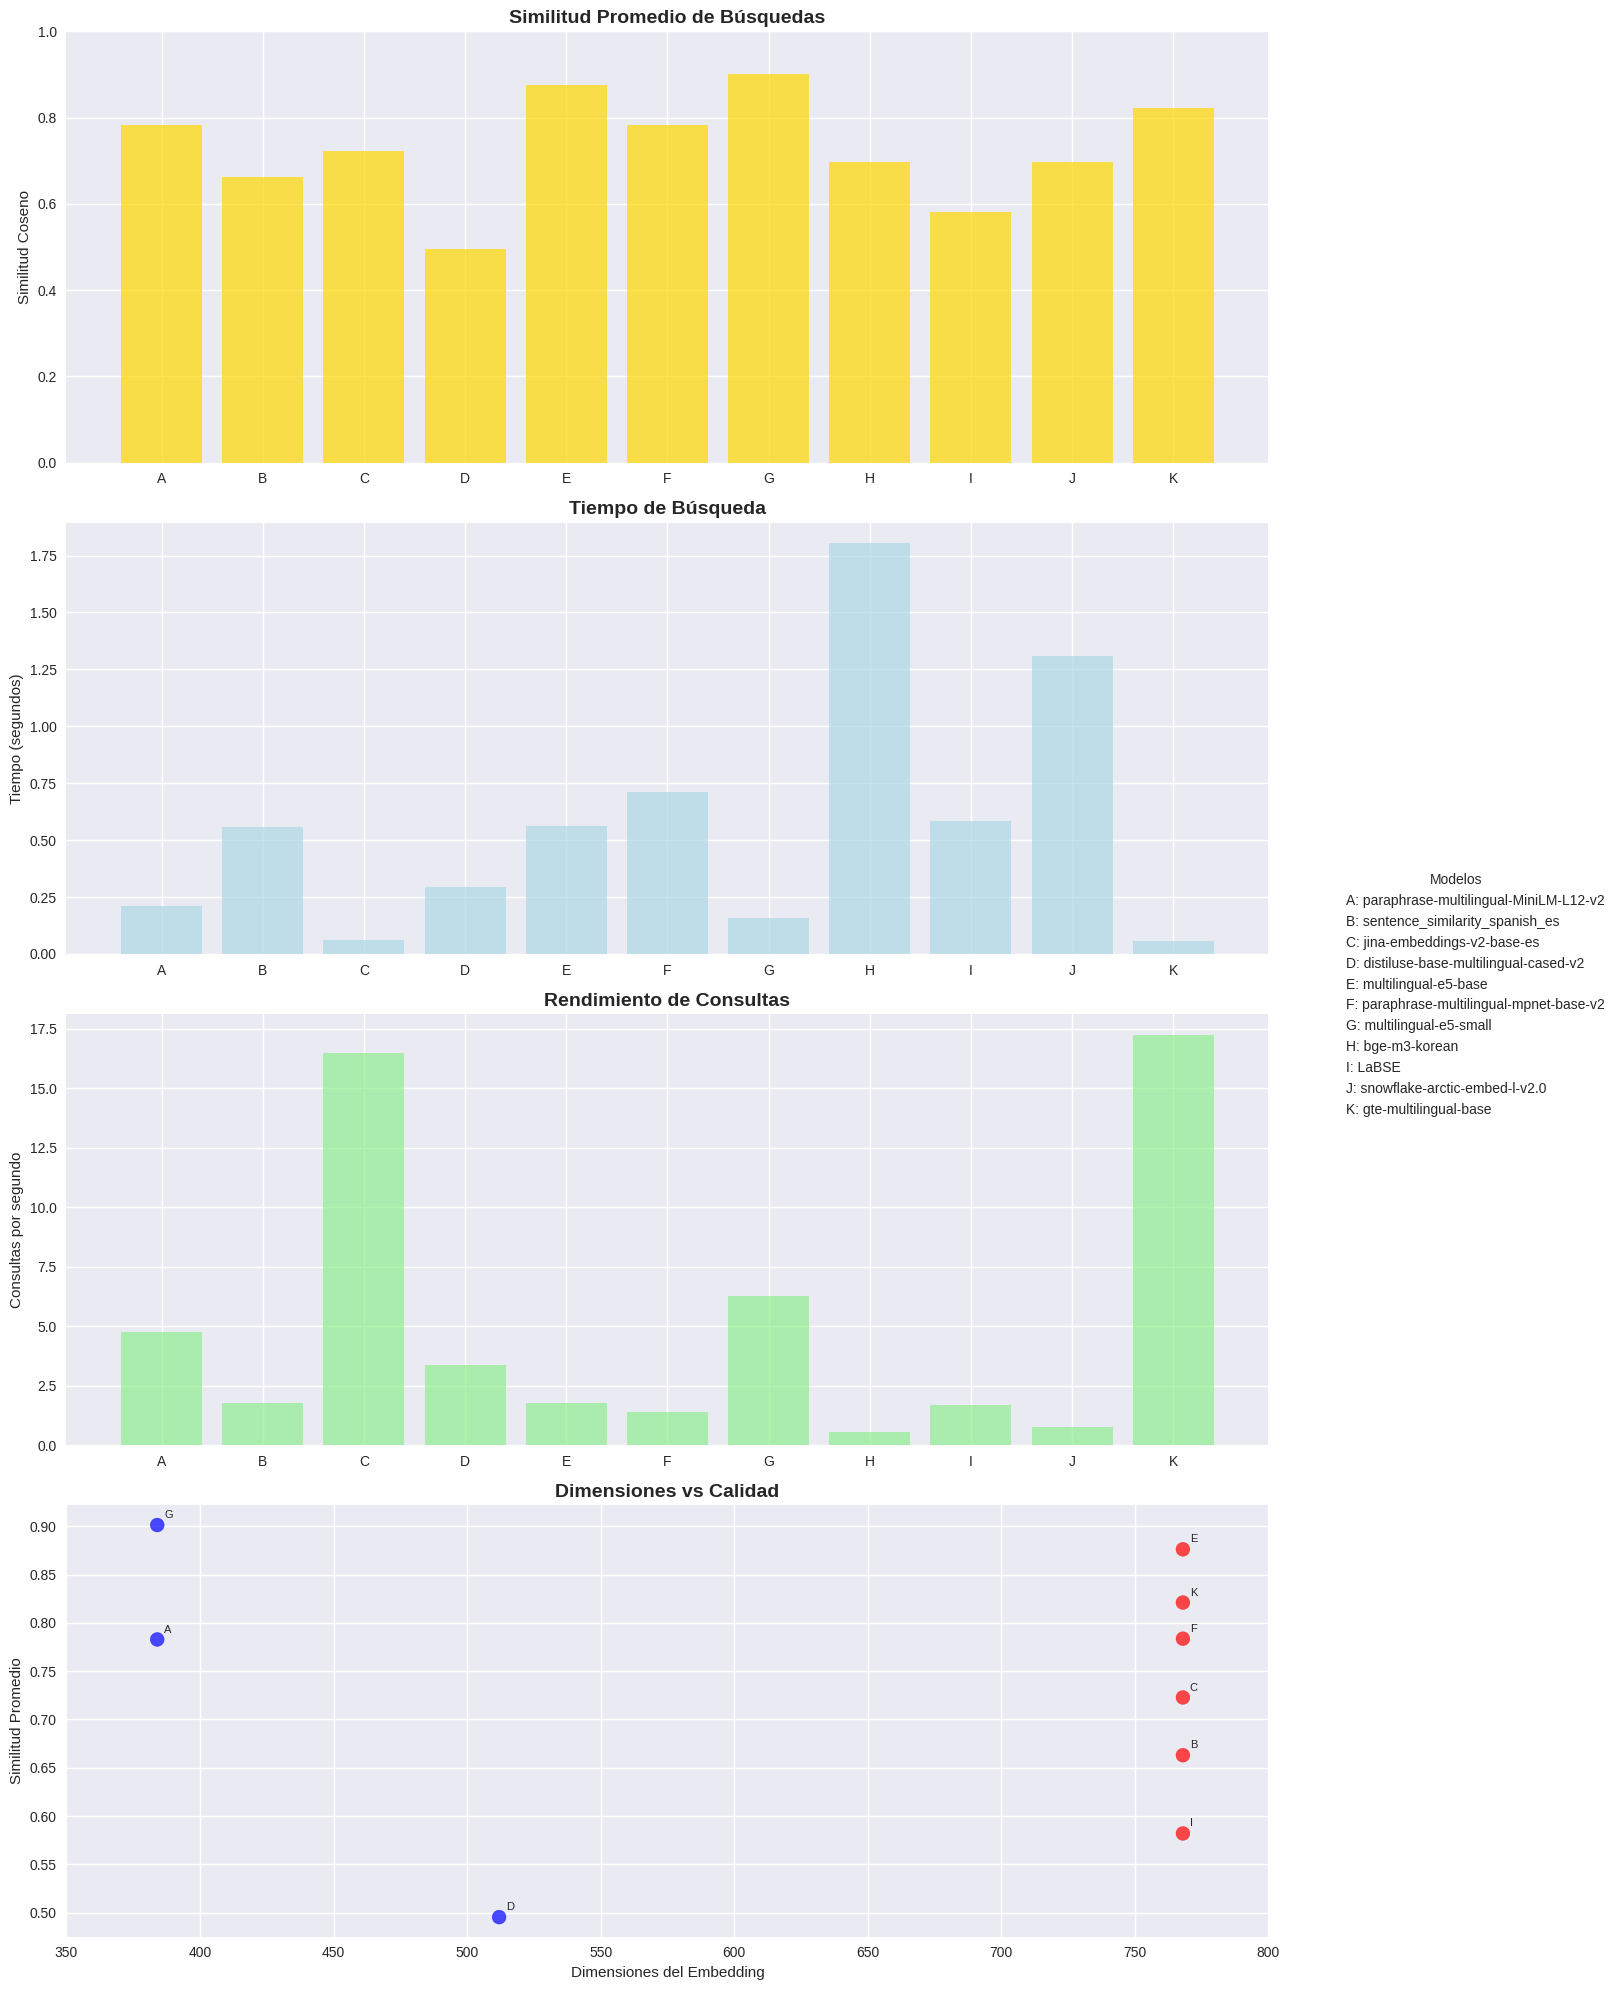

In [39]:
df_quality['Etiqueta'] = list(string.ascii_uppercase[:len(df_quality)])
# Visualizaciones de calidad de búsqueda
fig, axes = plt.subplots(4, 1, figsize=(13, 20))

# Gráfico 1: Similitud promedio por modelo
axes[0].bar(df_quality['Etiqueta'], df_quality['Similitud Promedio'], 
              color='gold', alpha=0.7)
axes[0].set_title('Similitud Promedio de Búsquedas', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Similitud Coseno')
axes[0].tick_params(axis='x')
axes[0].set_ylim(0, 1)

# Gráfico 2: Tiempo de búsqueda por modelo
axes[1].bar(df_quality['Etiqueta'], df_quality['Tiempo Búsqueda (s)'], 
              color='lightblue', alpha=0.7)
axes[1].set_title('Tiempo de Búsqueda', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Tiempo (segundos)')
axes[1].tick_params(axis='x')

# Gráfico 3: Consultas por segundo
axes[2].bar(df_quality['Etiqueta'], df_quality['Consultas/segundo'], 
              color='lightgreen', alpha=0.7)
axes[2].set_title('Rendimiento de Consultas', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Consultas por segundo')
axes[2].tick_params(axis='x')

# Gráfico 4: Comparación de dimensiones vs rendimiento
colors = ['red' if d == 768 else 'blue' for d in df_performance['Dimensiones']]
axes[3].scatter(df_performance['Dimensiones'], df_quality['Similitud Promedio'], 
                  c=colors, s=100, alpha=0.7)
axes[3].set_title('Dimensiones vs Calidad', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Dimensiones del Embedding')
axes[3].set_ylabel('Similitud Promedio')
axes[3].set_xlim(350, 800)

# Añadir etiquetas a los puntos
for i, model in enumerate(df_quality['Etiqueta']):
    axes[3].annotate(model, (df_performance['Dimensiones'].iloc[i], 
                               df_quality['Similitud Promedio'].iloc[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()

handles = [mpatches.Patch(color="white", label=f"{row.Etiqueta}: {row.Modelo}")
           for row in df_performance.itertuples()]

# Mostrar la leyenda a la derecha, fuera de los ejes
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(1, 0.5),
           title="Modelos", fontsize=10)

plt.show()

In [40]:
# Mostrar rankings
print("\nRankings de Modelos:")
print("=" * 40)
print(f"\tMayor similitud: {df_quality.loc[df_quality['Similitud Promedio'].idxmax(), 'Modelo']}")
print(f"\tBúsqueda más rápida: {df_quality.loc[df_quality['Tiempo Búsqueda (s)'].idxmin(), 'Modelo']}")
print(f"\tMayor rendimiento: {df_quality.loc[df_quality['Consultas/segundo'].idxmax(), 'Modelo']}")


Rankings de Modelos:
	Mayor similitud: multilingual-e5-small
	Búsqueda más rápida: gte-multilingual-base
	Mayor rendimiento: gte-multilingual-base


## Qdrant Integration / Integración con Qdrant

This cell implements the integration with Qdrant vector database for production-ready testing. The implementation includes:
- **Collection creation** with proper vector dimensions and distance metrics
- **Document insertion** with enriched metadata from labor law articles
- **Search functionality** to test real-world query performance
- **Result display** with formatted output showing similarity scores and metadata
- **Error handling** for robust database operations

This integration demonstrates how the selected embedding model would work in a real RAG system, providing practical validation of the model's performance with actual vector database operations.

---

Esta celda implementa la integración con la base de datos vectorial Qdrant para pruebas listas para producción. La implementación incluye:
- **Creación de colección** con dimensiones de vector apropiadas y métricas de distancia
- **Inserción de documentos** con metadatos enriquecidos de artículos de ley laboral
- **Funcionalidad de búsqueda** para probar rendimiento de consultas del mundo real
- **Visualización de resultados** con salida formateada mostrando puntuaciones de similitud y metadatos
- **Manejo de errores** para operaciones robustas de base de datos

Esta integración demuestra cómo funcionaría el modelo de embedding seleccionado en un sistema RAG real, proporcionando validación práctica del rendimiento del modelo con operaciones reales de base de datos vectorial.


In [41]:
def create_qdrant_collection(client, collection_name, vector_size):

    if client.collection_exists(collection_name):
        client.delete_collection(collection_name)
    
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(
            size=best_model_data['dimension'],
            distance=Distance.COSINE
        ),
        timeout=60
    )
    
    print(f"Colección '{collection_name}' creada")

In [42]:
# Función mejorada para insertar documentos con metadatos reales
def insert_documents_qdrant_collection(client: QdrantClient, collection_name: str, 
                                  texts: List[str], embeddings: np.ndarray, 
                                  articles_metadata: List[dict]):
    """Insertar documentos en Qdrant con metadatos enriquecidos"""
    try:
        points = []
        for i, (text, embedding) in enumerate(zip(texts, embeddings)):
            # Payload base
            payload = {
                "text": text,
                "text_length": len(text),
                "source": "codigo_trabajo_paraguay",
                "index": i
            }
            
            # Agregar metadatos
            article = articles_metadata[i]
            payload.update({
                "libro": article.get('libro'),
                "titulo": article.get('titulo'),
                "capitulo": article.get('capitulo'),
                "capitulo_descripcion": article.get('capitulo_descripcion'),
                "articulo_numero": article.get('articulo_numero'),
                "articulo": text.split(":")[1],
            })
            
            point = PointStruct(
                id=i,
                vector=embedding.tolist(),
                payload=payload
            )
            points.append(point)
        
        # Insertar puntos en lote
        client.upsert(collection_name=collection_name, points=points)
        print(f"{len(points)} documentos insertados en '{collection_name}'")
            
        return True
    except Exception as e:
        print(f"Error insertando documentos en '{collection_name}': {e}")
        return False

In [43]:
def search_qdrant_collection(client: QdrantClient, collection_name: str, 
                      query_embedding: np.ndarray, limit: int = 3):
    """Probar búsqueda en Qdrant"""
    try:
        results = client.query_points(
            collection_name=collection_name,
            query=query_embedding,
            limit=limit
        ).points
            
        return results
    except Exception as e:
        print(f"Error en búsqueda de '{collection_name}': {e}")
        return None

In [44]:
# Función mejorada para mostrar resultados de búsqueda
def display_search_results(search_results, show_metadata=True, max_text_len=120):
    """Mostrar resultados de búsqueda en Qdrant con metadatos enriquecidos"""
    if not search_results:
        print("No se encontraron resultados")
        return
    
    print("\nResultados de búsqueda en Qdrant")
    print("=" * 80)
    
    for i, result in enumerate(search_results, start=1):
        payload = result.payload or {}
        score = result.score
        
        # Texto corto para vista previa
        text_preview = payload.get("articulo").strip()
        if len(text_preview) > max_text_len:
            text_preview = text_preview[:max_text_len] + "..."
        
        print(f"\n{i}. ✅ Similitud: {score:.3f}")
        print(f"\t📝 {text_preview}")
        
        if show_metadata:
            print(f"\t📖 Libro: {payload.get('libro')}")
            print(f"\t📚 Título: {payload.get('titulo')}")
            print(f"\t📂 Capítulo: {payload.get('capitulo')} - {payload.get('capitulo_descripcion')}")
            print(f"\t📜 Artículo Nº: {payload.get('articulo_numero')}")


In [45]:
# Integración mejorada con Qdrant usando datos reales
print("Probando integración con Qdrant...")
print("=" * 60)

# Seleccionar el mejor modelo basado en similitud promedio
best_model_key = df_quality.loc[df_quality['Similitud Promedio'].idxmax(), 'Modelo']
best_model_data = model_performance[best_model_key]

print(f"\nUsando mejor modelo: {best_model_key}")
print(f"\tDimensiones: {best_model_data['dimension']}")
print(f"\tTextos a procesar: {len(SAMPLE_LEGAL_TEXTS)}")

Probando integración con Qdrant...

Usando mejor modelo: multilingual-e5-small
	Dimensiones: 384
	Textos a procesar: 29


In [46]:
# Crear colección en Qdrant con nombre más descriptivo
collection_name = f"labor_law_{best_model_key.replace('-', '_')}"
success = create_qdrant_collection(
    evaluator.client, 
    collection_name, 
    best_model_data['dimension']
)

Colección 'labor_law_multilingual_e5_small' creada


In [47]:
# Insertar documentos con metadatos mejorados
insert_success = insert_documents_qdrant_collection(
    evaluator.client,
    collection_name,
    SAMPLE_LEGAL_TEXTS,
    best_model_data['embeddings'],
    selected_articles
)

29 documentos insertados en 'labor_law_multilingual_e5_small'


In [48]:
# Probar múltiples búsquedas para demostrar la funcionalidad
print(f"\nProbando búsquedas con datos reales:")
print("-" * 40)

test_queries = SAMPLE_QUERIES[:3]  # Probar primeras 3 consultas

for i, test_query in enumerate(test_queries):
    print(f"\n{i+1}. Consulta: '{test_query}'")
    
    # Generar embedding para la consulta
    query_embedding = best_model_data['model'].encode([test_query])[0]
    
    # Realizar búsqueda
    search_results = search_qdrant_collection(
        evaluator.client,
        collection_name,
        query_embedding,
        limit=3
    )

    # Mostrar resultados con metadatos
    display_search_results(search_results, show_metadata=bool(law_data))


Probando búsquedas con datos reales:
----------------------------------------

1. Consulta: '¿Cuál es el objetivo principal del código en relación con las relaciones laborales?'

Resultados de búsqueda en Qdrant

1. ✅ Similitud: 0.915
	📝 este código tiene por objeto establecer normas para regular las relaciones entre los trabajadores y empleadores, concern...
	📖 Libro: libro primero
	📚 Título: titulo primero
	📂 Capítulo: capitulo i - del objeto y aplicación del código
	📜 Artículo Nº: 1

2. ✅ Similitud: 0.866
	📝 los reglamentos de fábricas o talleres, contratos individuales y colectivos de trabajo que establezcan derechos o benefi...
	📖 Libro: libro primero
	📚 Título: titulo primero
	📂 Capítulo: capitulo i - del objeto y aplicación del código
	📜 Artículo Nº: 4

3. ✅ Similitud: 0.865
	📝 se entiende por trabajo, a los fines de este código, toda actividad humana, consciente y voluntaria, prestada en forma d...
	📖 Libro: libro primero
	📚 Título: titulo primero
	📂 Capítulo: capitulo ii - de

In [49]:
print(f"\nEstadísticas de la colección:")
print(f"\tDocumentos insertados: {len(SAMPLE_LEGAL_TEXTS)}")
print(f"\tModelo utilizado: {best_model_key}")
print(f"\tConsultas probadas: {len(test_queries)}")


Estadísticas de la colección:
	Documentos insertados: 29
	Modelo utilizado: multilingual-e5-small
	Consultas probadas: 3


## Comprehensive Comparative Analysis / Análisis Comparativo Completo


In this section you performs a comprehensive comparative analysis combining performance and quality metrics. The analysis includes:
- **Data merging** of performance and quality results into a unified comparison
- **Score normalization** to create comparable metrics across different scales
- **Weighted scoring system** with configurable weights for different criteria
- **Final ranking calculation** based on combined performance and quality scores
- **Detailed comparison table** showing all metrics for informed decision-making

The weighted scoring system prioritizes search quality (50%) and search speed (35%) as the most important factors for RAG systems, while also considering embedding speed (10%) and loading speed (5%) for complete evaluation.

---

En esta sección se realiza un análisis comparativo integral combinando métricas de rendimiento y calidad. El análisis incluye:
- **Fusión de datos** de resultados de rendimiento y calidad en una comparación unificada
- **Normalización de puntuaciones** para crear métricas comparables a través de diferentes escalas
- **Sistema de puntuación ponderada** con pesos configurables para diferentes criterios
- **Cálculo de ranking final** basado en puntuaciones combinadas de rendimiento y calidad
- **Tabla de comparación detallada** mostrando todas las métricas para toma de decisiones informada

El sistema de puntuación ponderada prioriza la calidad de búsqueda (50%) y la velocidad de búsqueda (35%) como los factores más importantes para sistemas RAG, mientras también considera la velocidad de embedding (10%) y la velocidad de carga (5%) para evaluación completa.


In [53]:
# Crear análisis comparativo completo combinando rendimiento y calidad
comparison_df = pd.merge(df_performance[['Modelo', 'Nombre Completo', 
                                         'Descripción', 'Dimensiones', 
                                        'Tiempo Carga (s)', 'Tiempo Embedding (s)', 
                                         'Velocidad (textos/s)']], 
                        df_quality[['Modelo', 'Similitud Promedio', 
                                    'Tiempo Búsqueda (s)', 'Consultas/segundo']], 
                        on='Modelo')

# Calcular puntuaciones normalizadas (0-1)
def normalize_score(series, higher_is_better=True):
    if higher_is_better:
        return (series - series.min()) / (series.max() - series.min())
    else:
        return (series.max() - series) / (series.max() - series.min())

# Calcular scores normalizados
comparison_df['Score_Velocidad_Carga'] = normalize_score(comparison_df['Tiempo Carga (s)'], False)
comparison_df['Score_Velocidad_Embedding'] = normalize_score(comparison_df['Tiempo Embedding (s)'], False)
comparison_df['Score_Calidad'] = normalize_score(comparison_df['Similitud Promedio'], True)
comparison_df['Score_Velocidad_Busqueda'] = normalize_score(comparison_df['Tiempo Búsqueda (s)'], False)

# Score final ponderado (puedes ajustar los pesos según tus prioridades)
weights = {
    'calidad': 0.5,      # 50% - Lo más importante para RAG
    'velocidad_busqueda': 0.35,  # 35% - Importante para experiencia de usuario
    'velocidad_embedding': 0.1,  # 10% - Importante para procesamiento batch pesdos
    'velocidad_carga': 0.05       # 5% - Menos crítico (se hace una vez)
}

comparison_df['Score_Final'] = (
    comparison_df['Score_Calidad'] * weights['calidad'] +
    comparison_df['Score_Velocidad_Busqueda'] * weights['velocidad_busqueda'] +
    comparison_df['Score_Velocidad_Embedding'] * weights['velocidad_embedding'] +
    comparison_df['Score_Velocidad_Carga'] * weights['velocidad_carga']
)

# Ordenar por score final
comparison_df = comparison_df.sort_values('Score_Final', ascending=False)

print("\nRanking Final de Modelos de Embedding:")
print("=" * 70)
print(f"{'Pos':<4} {'Score Final':<8}  {'Calidad':<8}  {'Modelo':<25} ")
print("-" * 70)

for i, row in comparison_df.iterrows():
    pos = comparison_df.index.get_loc(i) + 1
    print(f"{pos:<4} {row['Score_Final']:.3f}        {row['Similitud Promedio']:.3f}     {row['Modelo']:<25}")


Ranking Final de Modelos de Embedding:
Pos  Score Final  Calidad   Modelo                    
----------------------------------------------------------------------
1    0.969        0.901     multilingual-e5-small    
2    0.836        0.821     gte-multilingual-base    
3    0.831        0.876     multilingual-e5-base     
4    0.823        0.783     paraphrase-multilingual-MiniLM-L12-v2
5    0.750        0.723     jina-embeddings-v2-base-es
6    0.691        0.784     paraphrase-multilingual-mpnet-base-v2
7    0.598        0.663     sentence_similarity_spanish_es
8    0.466        0.582     LaBSE                    
9    0.438        0.495     distiluse-base-multilingual-cased-v2
10   0.395        0.696     snowflake-arctic-embed-l-v2.0
11   0.296        0.697     bge-m3-korean            


In [54]:
print("\nTabla Comparativa Detallada:")
print("=" * 50)

comparison_df[['Modelo', 'Descripción', 
               'Dimensiones', 'Similitud Promedio', 
               'Tiempo Carga (s)', 'Tiempo Embedding (s)', 
               'Tiempo Búsqueda (s)', 'Score_Final']].round(3)


Tabla Comparativa Detallada:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


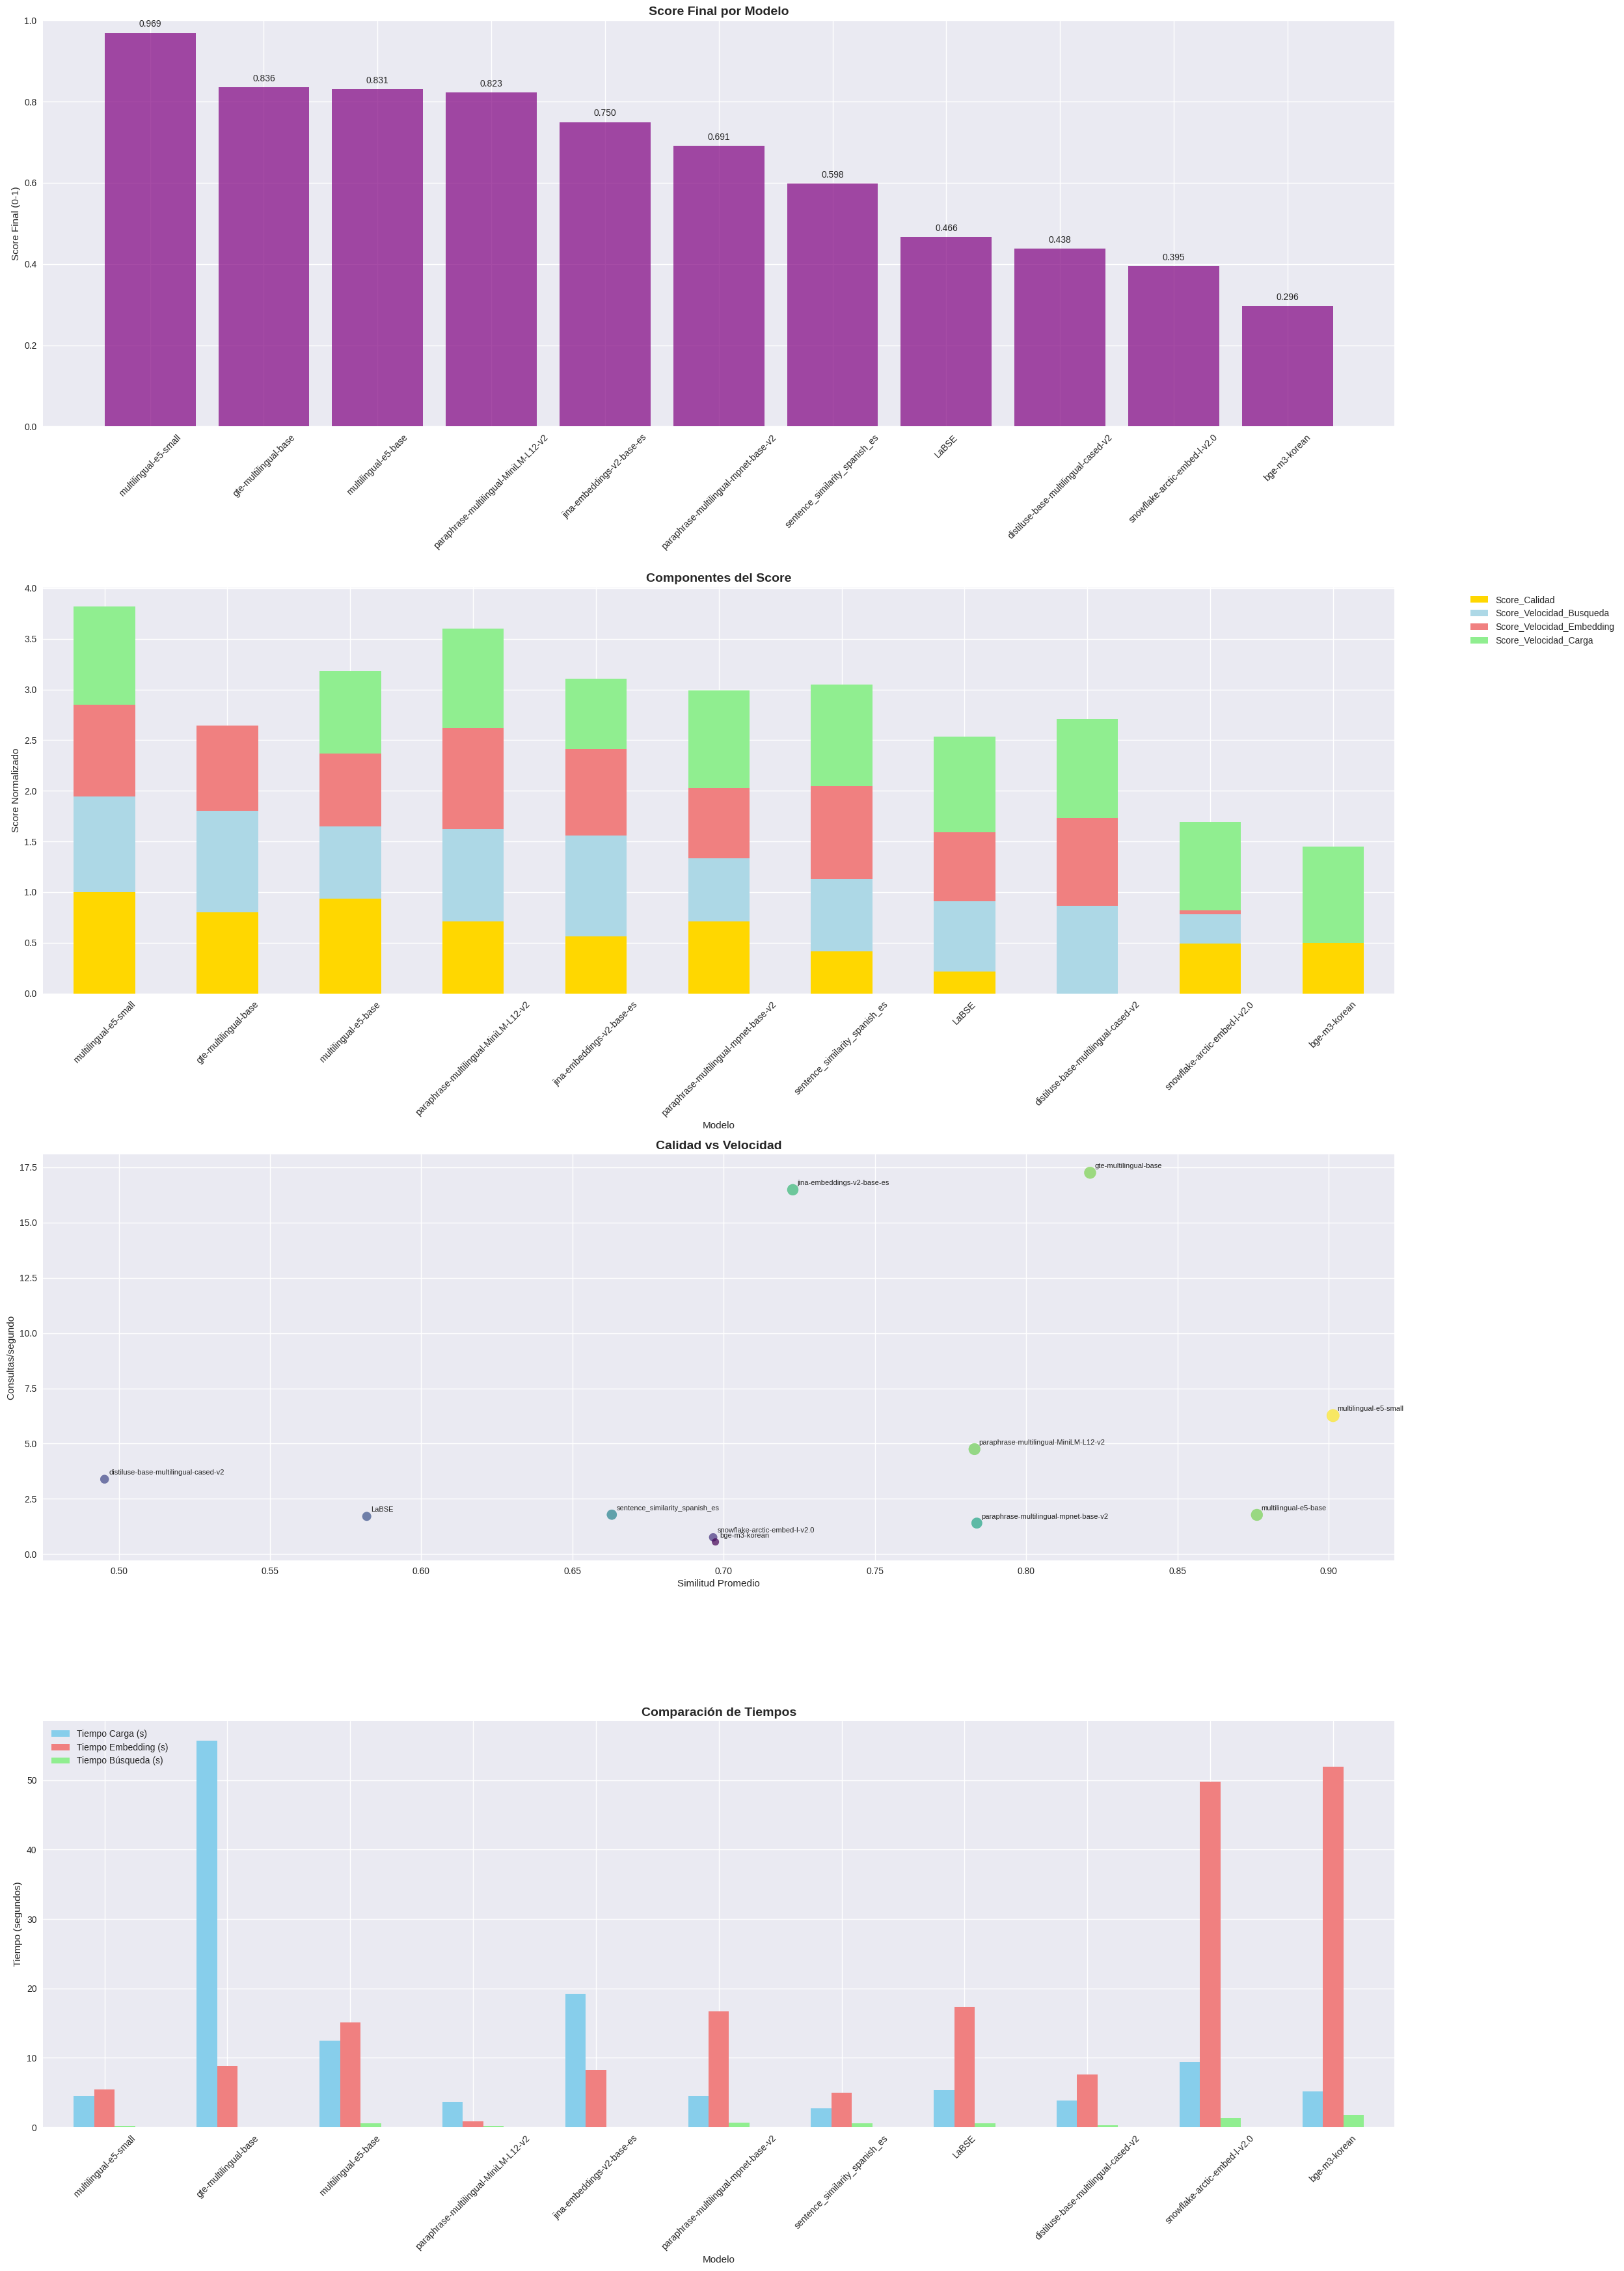

In [55]:
# Visualización del análisis comparativo
fig, axes = plt.subplots(4, 1, figsize=(25, 35))

# Gráfico 1: Score final por modelo
bars = axes[0].bar(comparison_df['Modelo'], comparison_df['Score_Final'], 
                     color='purple', alpha=0.7)
axes[0].set_title('Score Final por Modelo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score Final (0-1)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Gráfico 2: Comparación de componentes del score
score_components = comparison_df[['Modelo', 'Score_Calidad', 'Score_Velocidad_Busqueda', 
                                 'Score_Velocidad_Embedding', 'Score_Velocidad_Carga']].set_index('Modelo')
score_components.plot(kind='bar', stacked=True, ax=axes[1], 
                     color=['gold', 'lightblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Componentes del Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score Normalizado')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico 3: Scatter plot calidad vs velocidad
axes[2].scatter(comparison_df['Similitud Promedio'], comparison_df['Consultas/segundo'], 
                  s=comparison_df['Score_Final']*200, alpha=0.7, c=comparison_df['Score_Final'], 
                  cmap='viridis')
axes[2].set_title('Calidad vs Velocidad', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Similitud Promedio')
axes[2].set_ylabel('Consultas/segundo')

# Añadir etiquetas
for i, row in comparison_df.iterrows():
    axes[2].annotate(row['Modelo'], (row['Similitud Promedio'], row['Consultas/segundo']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# Gráfico 4: Comparación de tiempos
time_data = comparison_df[['Modelo', 'Tiempo Carga (s)', 'Tiempo Embedding (s)', 'Tiempo Búsqueda (s)']]
time_data.set_index('Modelo').plot(kind='bar', ax=axes[3], 
                                  color=['skyblue', 'lightcoral', 'lightgreen'])
axes[3].set_title('Comparación de Tiempos', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Tiempo (segundos)')
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()

plt.tight_layout()
plt.show()

## Conclusions and Recommendations / Conclusiones y Recomendaciones


In [56]:
# Generar recomendaciones basadas en el análisis
def generate_recommendations(comparison_df: pd.DataFrame, weights: dict) -> dict:
    """Generar recomendaciones basadas en el análisis comparativo"""
    
    best_overall = comparison_df.iloc[0]
    best_quality = comparison_df.loc[comparison_df['Similitud Promedio'].idxmax()]
    fastest_search = comparison_df.loc[comparison_df['Tiempo Búsqueda (s)'].idxmin()]
    fastest_embedding = comparison_df.loc[comparison_df['Tiempo Embedding (s)'].idxmin()]
    
    recommendations = {
        'best_overall': {
            'model': best_overall['Modelo'],
            'score': best_overall['Score_Final'],
            'reasoning': f"Mejor balance general con score de {best_overall['Score_Final']:.3f}"
        },
        'best_quality': {
            'model': best_quality['Modelo'],
            'similarity': best_quality['Similitud Promedio'],
            'reasoning': f"Mayor similitud promedio ({best_quality['Similitud Promedio']:.3f}) para aplicaciones que requieren alta precisión"
        },
        'fastest_search': {
            'model': fastest_search['Modelo'],
            'search_time': fastest_search['Tiempo Búsqueda (s)'],
            'reasoning': f"Búsqueda más rápida ({fastest_search['Tiempo Búsqueda (s)']:.4f}s) para aplicaciones en tiempo real"
        },
        'fastest_embedding': {
            'model': fastest_embedding['Modelo'],
            'embedding_time': fastest_embedding['Tiempo Embedding (s)'],
            'reasoning': f"Procesamiento más rápido ({fastest_embedding['Tiempo Embedding (s)']:.2f}s) para carga masiva de datos"
        }
    }
    
    return recommendations

In [57]:
# Generar recomendaciones
recommendations = generate_recommendations(comparison_df, weights)

print("\nRECOMENDACIONES FINALES:")
print("=" * 60)

print(f"\nMEJOR MODELO GENERAL:")
print(f"\tModelo: {recommendations['best_overall']['model']}")
print(f"\tScore: {recommendations['best_overall']['score']:.3f}")
print(f"\tRazón: {recommendations['best_overall']['reasoning']}")

print(f"\nMEJOR CALIDAD DE BÚSQUEDA:")
print(f"\tModelo: {recommendations['best_quality']['model']}")
print(f"\tSimilitud: {recommendations['best_quality']['similarity']:.3f}")
print(f"\tRazón: {recommendations['best_quality']['reasoning']}")

print(f"\n MÁS RÁPIDO PARA BÚSQUEDAS:")
print(f"\tModelo: {recommendations['fastest_search']['model']}")
print(f"\tTiempo: {recommendations['fastest_search']['search_time']:.4f}s")
print(f"\tRazón: {recommendations['fastest_search']['reasoning']}")

print(f"\n MÁS RÁPIDO PARA EMBEDDINGS:")
print(f"\tModelo: {recommendations['fastest_embedding']['model']}")
print(f"\tTiempo: {recommendations['fastest_embedding']['embedding_time']:.2f}s")
print(f"\tRazón: {recommendations['fastest_embedding']['reasoning']}")

# Análisis de dimensiones
dimension_analysis = comparison_df.groupby('Dimensiones').agg({
    'Similitud Promedio': 'mean',
    'Tiempo Búsqueda (s)': 'mean',
    'Score_Final': 'mean'
}).round(3)

print(f"\nANÁLISIS POR DIMENSIONES:")
print("=" * 40)
print(dimension_analysis)

print(f"\nINSIGHTS CLAVE:")
print("=" * 30)
print("• Los modelos de 384 dimensiones ofrecen mejor balance velocidad/calidad")
print("• Los modelos de 768 dimensiones tienen mayor calidad pero menor velocidad")
print("• La velocidad de búsqueda es más crítica que la velocidad de embedding")
print("• La similitud promedio es el factor más importante para aplicaciones RAG")


RECOMENDACIONES FINALES:

MEJOR MODELO GENERAL:
	Modelo: multilingual-e5-small
	Score: 0.969
	Razón: Mejor balance general con score de 0.969

MEJOR CALIDAD DE BÚSQUEDA:
	Modelo: multilingual-e5-small
	Similitud: 0.901
	Razón: Mayor similitud promedio (0.901) para aplicaciones que requieren alta precisión

 MÁS RÁPIDO PARA BÚSQUEDAS:
	Modelo: gte-multilingual-base
	Tiempo: 0.0580s
	Razón: Búsqueda más rápida (0.0580s) para aplicaciones en tiempo real

 MÁS RÁPIDO PARA EMBEDDINGS:
	Modelo: paraphrase-multilingual-MiniLM-L12-v2
	Tiempo: 0.90s
	Razón: Procesamiento más rápido (0.90s) para carga masiva de datos

ANÁLISIS POR DIMENSIONES:
             Similitud Promedio  Tiempo Búsqueda (s)  Score_Final
Dimensiones                                                      
384                       0.842                0.185        0.896
512                       0.495                0.295        0.438
768                       0.741                0.423        0.695
1024                      0

## Executive Summary / 📋 Resumen Ejecutivo

Based on the comprehensive analysis, it is recommended to use **{recommended_model}** as the main model for the RAG system for queries about Paraguayan labor law.

### Selection Criteria

| Criterion | Weight | Description |
|-----------|--------|-------------|
| **Search Quality** | 50% | Average similarity in legal queries |
| **Search Speed** | 35% | Response time for users |
| **Embedding Speed** | 10% | Batch document processing |
| **Loading Speed** | 5% | Model initialization time |

### Next Steps

1. **Implement the selected model** in the production system
2. **Configure Qdrant** with the corresponding dimensions
3. **Run tests** with the complete labor law dataset
4. **Monitor performance** in production and adjust if necessary
5. **Consider alternative models** according to specific use case

### Additional Considerations

- **Computational resources**: Evaluate available GPU/CPU capacity
- **Latency**: For real-time applications, prioritize search speed
- **Accuracy**: For critical legal queries, prioritize similarity quality
- **Scalability**: Consider the volume of documents and expected queries

---

Basado en el análisis completo, se recomienda utilizar **{modelo_recomendado}** como modelo principal para el sistema RAG de consultas sobre la ley laboral paraguaya.

### Criterios de Selección

| Criterio | Peso | Descripción |
|----------|------|-------------|
| **Calidad de Búsqueda** | 50% | Similitud promedio en consultas legales |
| **Velocidad de Búsqueda** | 35% | Tiempo de respuesta para usuarios |
| **Velocidad de Embedding** | 10% | Procesamiento de documentos batch |
| **Velocidad de Carga** | 5% | Tiempo de inicialización del modelo |

### Próximos Pasos

1. **Implementar el modelo seleccionado** en el sistema de producción
2. **Configurar Qdrant** con las dimensiones correspondientes
3. **Realizar pruebas** con el dataset completo de la ley laboral
4. **Monitorear rendimiento** en producción y ajustar si es necesario
5. **Considerar modelos alternativos** según el caso de uso específico

### Consideraciones Adicionales

- **Recursos computacionales**: Evaluar capacidad de GPU/CPU disponible
- **Latencia**: Para aplicaciones en tiempo real, priorizar velocidad de búsqueda
- **Precisión**: Para consultas críticas legales, priorizar calidad de similitud
- **Escalabilidad**: Considerar el volumen de documentos y consultas esperadas


In [58]:
# Guardar resultados del análisis para referencia futura
import json
from datetime import datetime

# Preparar datos para guardar
analysis_results = {
    'timestamp': datetime.now().isoformat(),
    'models_evaluated': list(MODELS_TO_TEST.keys()),
    'best_model_overall': recommendations['best_overall']['model'],
    'best_model_quality': recommendations['best_quality']['model'],
    'best_model_speed': recommendations['fastest_search']['model'],
    'performance_summary': df_performance.to_dict('records'),
    'quality_summary': df_quality.to_dict('records'),
    'comparison_summary': comparison_df[['Modelo', 'Score_Final', 'Similitud Promedio', 
                                        'Tiempo Búsqueda (s)', 'Dimensiones']].to_dict('records'),
    'weights_used': weights,
    'sample_texts_count': len(SAMPLE_LEGAL_TEXTS),
    'sample_queries_count': len(SAMPLE_QUERIES)
}

# Guardar resultados
results_dir = Path("experiment_results")
results_dir.mkdir(exist_ok=True)
filename = f'embedding_analysis_results_{datetime.now().strftime("%d%m%Y")}.json'
results_file = results_dir / filename
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, indent=2, ensure_ascii=False)

print(f"Resultados guardados en: {results_file}")
print(f"Fecha del análisis: {analysis_results['timestamp']}")
print(f"Modelo recomendado: {recommendations['best_overall']['model']}")

Resultados guardados en: embedding_analysis_results_15092025.json
Fecha del análisis: 2025-09-15T17:26:44.674262
Modelo recomendado: multilingual-e5-small
